# 算法原理

Baggging 和Boosting都是模型融合的方法，可以将弱分类器融合之后形成一个强分类器，而且融合之后的效果会比最好的弱分类器更好。

## Bagging

- 用抽样的方式从原始样本中进行有放回的多次抽样（或者是抽特征），这种方法叫做Bootstraping，抽取k次每次抽取n个样本，这样就生成了k个样本容量为n的数据集。原始数据集中的样本可能是多次被抽到也可能是没有被抽到。
- 每次使用一个数据即得到一个模型，这样k个数据集就可以得到k个模型。（模型可以是根据问题来选择，回归或者分类模型都可以）这里就得到了k个弱分类器。
- 对新的数据使用所有的模型进行分类，然后采用voting的方式来确定结果。统计所有模型的计算结果，然后选出票数最高的那个作为结果。（如果是回归问题则以所有模型的均值作为最终结果。）

## Boosting

boosting与bagging不同的是，bagging是多个模型“并行”，voting决定结果；而boosting是多个模型串行，通过多个模型的结果相加得到最终的结果。

AdaBoosting方式每次使用的是全部的样本，每轮训练改变样本的权重。下一轮训练的目标是找到一个函数f 来拟合上一轮的残差。当残差足够小或者达到设置的最大迭代次数则停止。Boosting会减小在上一轮训练正确的样本的权重，增大错误样本的权重。（对的残差小，错的残差大）

梯度提升的Boosting方式是使用代价函数对上一轮训练出的模型函数f的偏导来拟合残差。

## stacking

所谓的Stacking就是通过模型对原数据拟合的堆叠进行建模，他首先通过基学习器学习原数据，然后这几个基学习器都会对原数据进行输出，然后将这几个模型的输出按照列的方式进行堆叠，构成了 ( m , p ) (m,p)(m,p) 维的新数据，m代表样本数，p代表基学习器的个数，然后将新的样本数据交给第二层模型进行拟合。
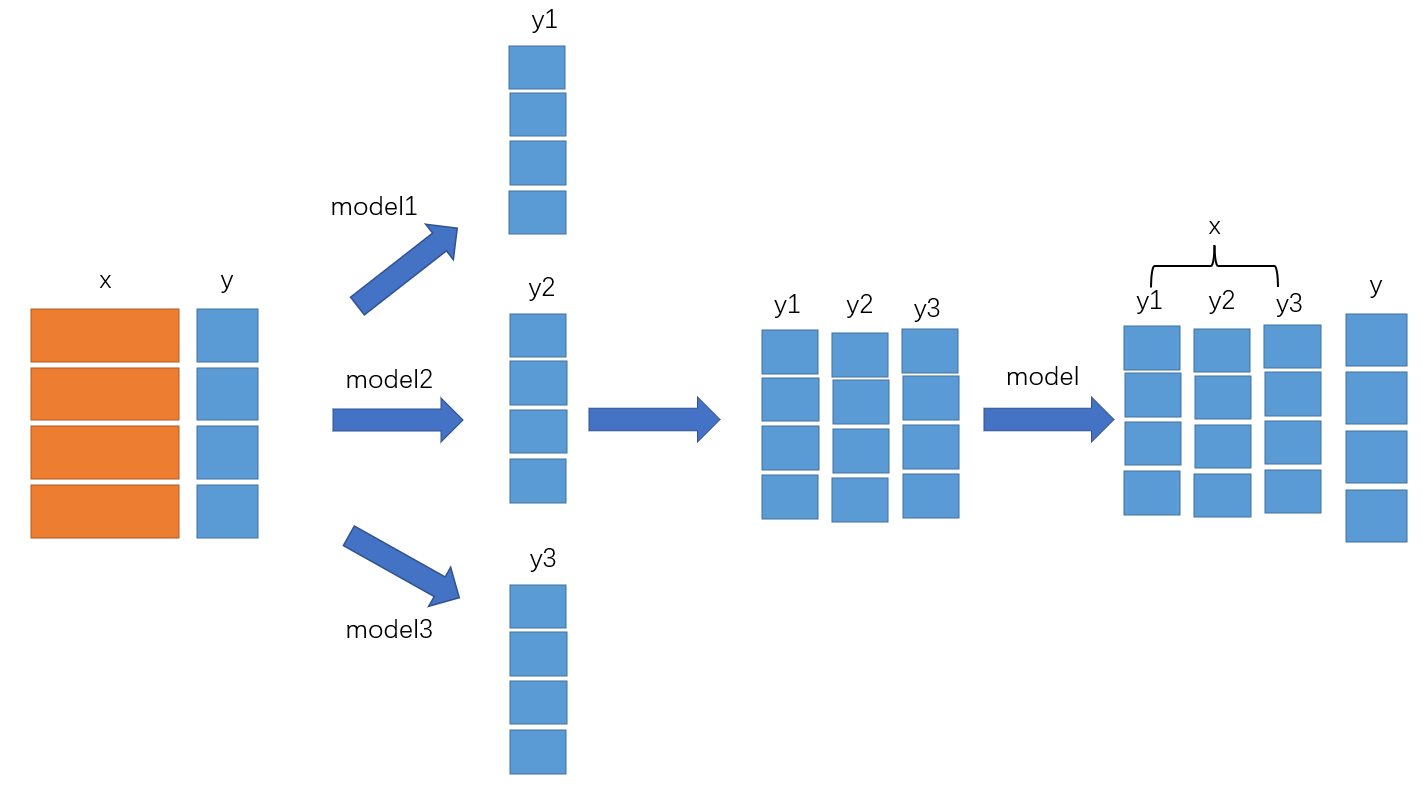

上图的意思就是首先将特征x和标签y分别输入到3个模型中，然后这3个模型分别学习，然后针对于x给出预测值，有时也会给出proba概率，这里我们使用预测值，然后将3个模型的输出值按照列的防止进行堆叠，这就形成了新的样本数据，然后将新的样本数据作为标签x，新数据的标签仍然为原数据的标签y，将新数据的x，y交给第二层的模型进行拟合，这个模型是用来融合前一轮3个模型结果的。

但是这样模型往往会过拟合，所以将上述方法进行改进，使用K折交叉验证的方式，不同的地方就是上面的示意图每个模型训练了所有的数据，然后输出y形成新的数据，使用K折交叉验证，每次只训练k-1折，然后将剩下1折的预测值作为新的数据，这就有效的防止了过拟合。

如果每个模型训练所有的数据，然后再用这个模型去预测y值，那么生成新数据的y非常精确和真实值差不多，为了增强模型的泛化能力，我们每次只训练其中一部分数据，然后用剩余一部分数据进行预测。
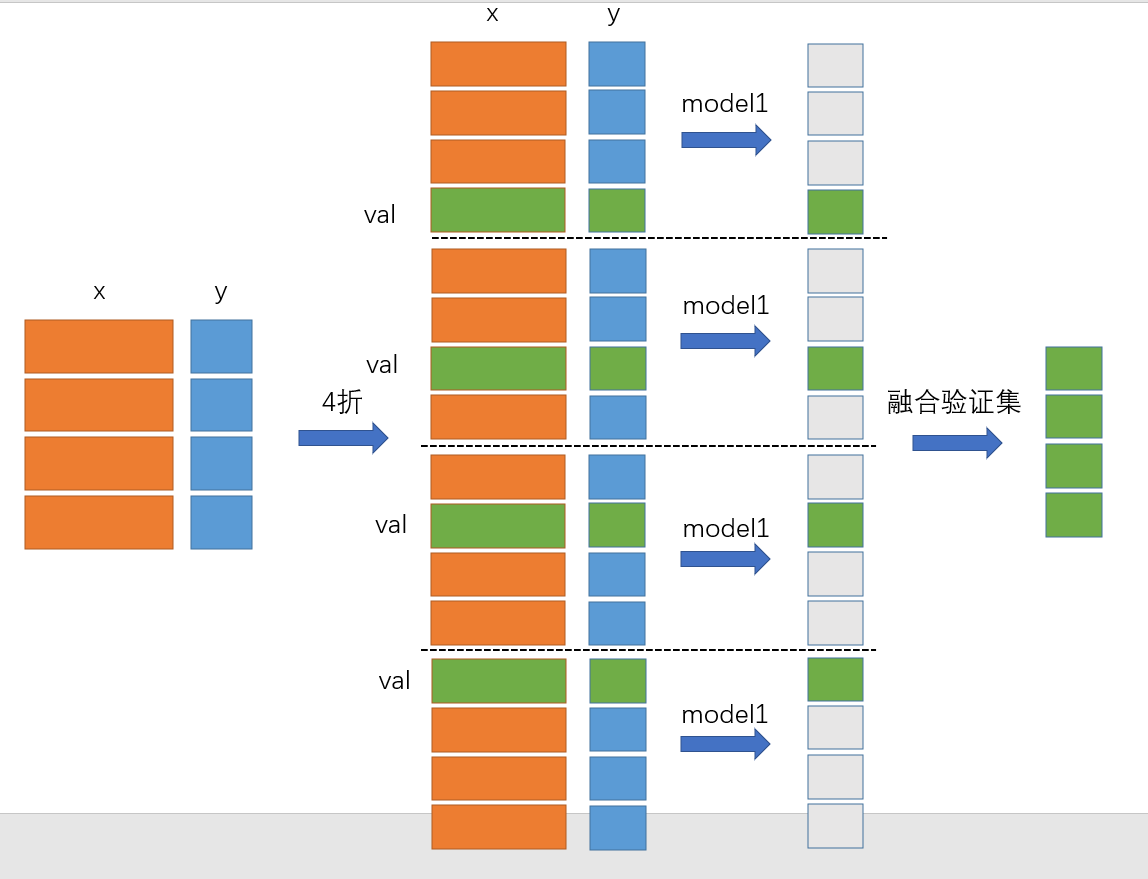

首先利用K折交叉验证，将数据分成4折切分，那么就会形成4组数据集，其中黄色代表训练集，绿色的为验证集，然后将每组的训练集交给模型进行训练，然后对验证集进行预测，就会得到对应验证集的输出，因为4折交叉验证，将数据分成4组，所以我们会形成4个验证集，然后将每个模型对各自组的验证集预测的结果进行按照行的方式堆叠，就会获得完整样本数据的预测值，这只是针对于一个模型，不同学习器同理，每个模型按照这个方式获得预测值，然后再将其按照列合并。


## 区别

1. 训练集

Bagging：每个训练集都是从原始训练集中有放回的选取出来的，每个训练集各不相同且相互独立。  
Boosting：每一轮的训练集都是原始选练集，只是每次训练后会根据本轮的训练结果调整训练集中的各个样本的权重，调整完权重的训练集用于下一轮的训练。  

2. 样本权重
  
Bagging：使用Bootstraping的方式均匀抽样  
Boosting：根据每一轮的训练不断调整权值，分类错误的样本拥有更高的权值。  

3. 弱分类器权重

Bagging：所有弱分类器权重相同，使用voting的方式（或均值）决定最终结果。  
Boosting：每个弱分类器都有相应的权重，对于分类误差小的分类器会有更大的权重。  

4. 并行计算

Bagging：各个预测函数可以并行生成，因为数据集相互独立，每个模型之间也独立，没有序列关系。  
Boosting：各个预测函数只能顺序生成，因为下一个模型的产生依赖于之前模型的计算结果。  


## 为什么bagging可以减少方差，而boosting是减少偏差？

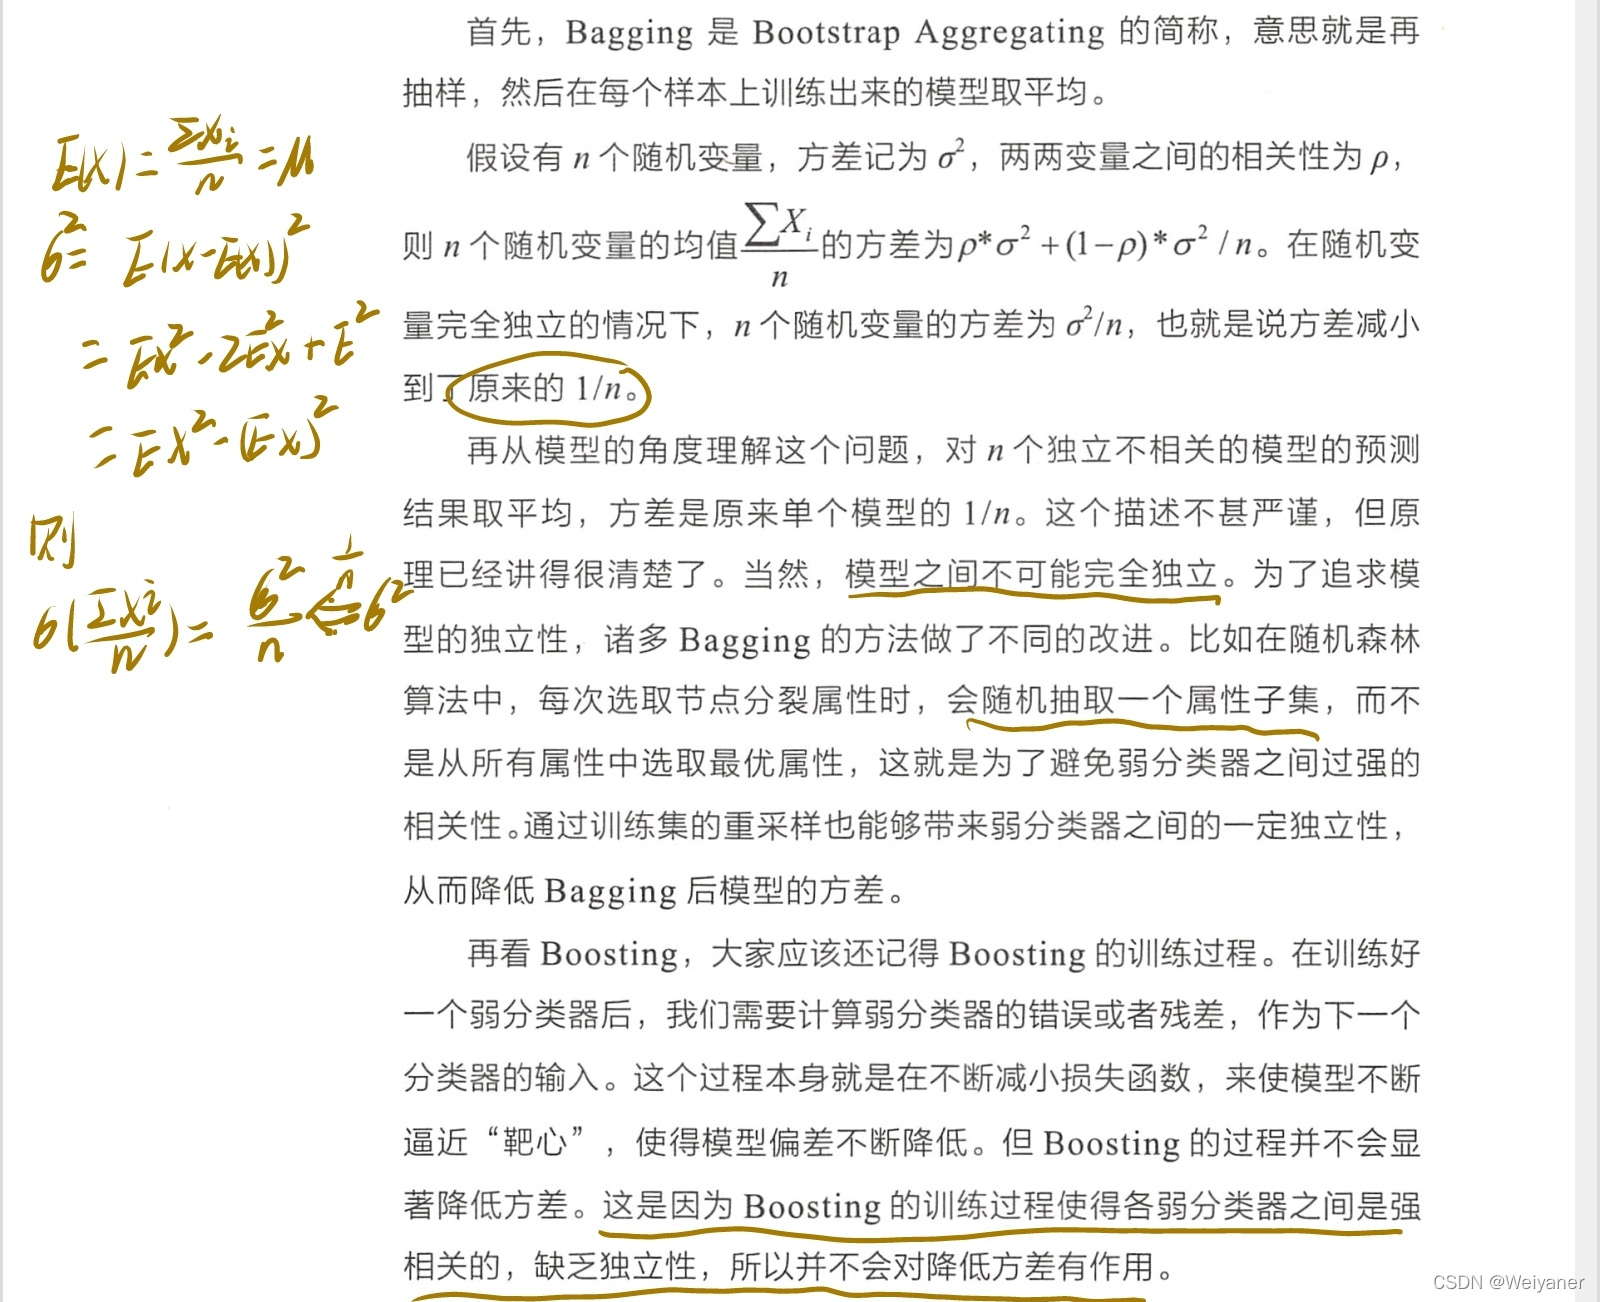

# 代码实现

In [2]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


class MyStacking:

    # 初始化模型参数
    def __init__(self, estimators, final_estimator, cv=5, method='predict'):
        self.cv = cv
        self.method = method
        self.estimators = estimators
        self.final_estimator = final_estimator

    # 模型训练
    def fit(self, X, y):
        # 获得一级输出
        dataset_train = self.stacking(X, y)

        # 模型融合
        self.final_estimator.fit(dataset_train, y)

    # 堆叠输出
    def stacking(self, X, y):
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=2021)
        # 获得一级输出
        dataset_train = np.zeros((X.shape[0], len(self.estimators)))
        for i, model in enumerate(self.estimators):
            for (train, val) in kf.split(X, y):
                X_train = X[train]
                X_val = X[val]
                y_train = y[train]

                y_val_pred = model.fit(X_train, y_train).predict(X_val)
                dataset_train[val, i] = y_val_pred
            self.estimators[i] = model
        return dataset_train

    # 模型预测
    def predict(self, X):
        datasets_test = np.zeros((X.shape[0], len(self.estimators)))
        for i, model in enumerate(self.estimators):
            datasets_test[:, i] = model.predict(X)

        return self.final_estimator.predict(datasets_test)

    # 模型精度
    def score(self, X, y):
        datasets_test = np.zeros((X.shape[0], len(self.estimators)))
        for i, model in enumerate(self.estimators):
            datasets_test[:, i] = model.predict(X)
        return self.final_estimator.score(datasets_test, y)


if __name__ == '__main__':
    X, y = load_iris(return_X_y=True)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, random_state=0)

    estimators = [
        RandomForestClassifier(n_estimators=10),
        GradientBoostingClassifier(n_estimators=10)
    ]

    clf = MyStacking(estimators=estimators,
                     final_estimator=LogisticRegression())

    clf.fit(X_train, y_train)

    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))

1.0
0.9777777777777777
